In [93]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import matplotlib.pyplot as plt
from scipy import linalg as la
from netCDF4 import Dataset

In [94]:
# Lectura de los datos
path_data = '/home/choyos/AnalisisDatos_022019/Datos/data_sst/' 
file_sst  = 'sst.mnmean.nc'
file_mask = 'lsmask.nc'

In [95]:
data_sst = Dataset(path_data+file_sst)
data_land = Dataset(path_data+file_mask)

In [96]:
lat_sst = data_sst.variables['lat'][:]
lon_sst = data_sst.variables['lon'][:]
sst     = data_sst.variables['sst'][:]

In [97]:
print (np.shape(sst))

(455, 180, 360)


lat_mask = data_land['lat'][:] 
lon_mask = data_land['lon'][:]
mask     = data_land['mask'][:]

In [99]:
# cortamos en algunas lot and lat
lat_b1 = -40.
lat_b2 = 40.
lon_b1 = 120.
lon_b2 = 280.

mask = mask.astype('float')
mask[mask == 0.] = np.nan
sst_mask = sst*mask

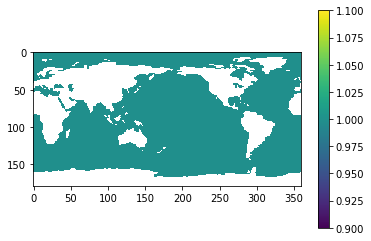

In [102]:
plt.imshow(mask)
plt.colorbar()
plt.show()

In [103]:
# se crea la matrix A
A = np.reshape(sst_mask, (np.shape(sst_mask)[0], np.shape(sst_mask)[1]*np.shape(sst_mask)[2]))

In [104]:
# Buscamos las columnas donde son nan
# con el fin de quitar los continentes 
fila1_A = np.array(A[0,:])
pos_cont = np.isnan(fila1_A)
pos_sst  = (np.where(pos_cont == False))[0]
A_no_land = A[:, pos_sst]
print np.shape(A)
print np.shape(A_no_land)

(455, 64800)
(455, 44219)


In [105]:
# hacemos fourier entre todos
sst_nomean = A_no_land - np.nanmean(A_no_land, axis = 0)
freq_sst   = np.fft.fftfreq(np.shape(sst_nomean)[0])
m_fourier  = np.ones((np.shape(sst_nomean)[0], np.shape(sst_nomean)[1])) * np.nan
for col in range(np.shape(A_no_land)[1]):
    fft_ssti = np.fft.fft(sst_nomean[:, col])
    fft_sst_filt = np.copy(fft_ssti)
    fft_sst_filt[np.where((np.abs(1/freq_sst)>(12*6)) | \
                          (np.abs(1/freq_sst)<((12*2))))]=0
    sst_nino=np.fft.ifft(fft_sst_filt)
    m_fourier[:, col] = sst_nino

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


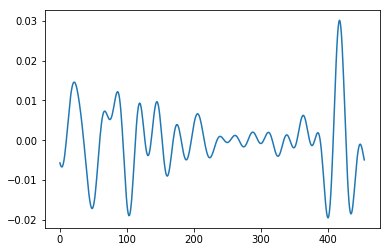

In [106]:
plt.plot(m_fourier[:, 2000])
plt.show()

In [107]:
# hacemos las EOF
cov_m1 = np.dot(m_fourier, m_fourier.T)
eigval_covm1, eigvect_covm1 = la.eig(cov_m1)

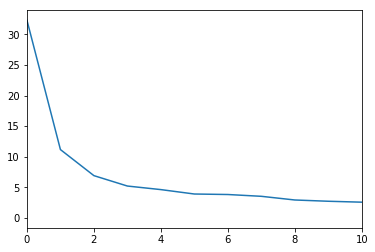

In [108]:
plt.plot((eigval_covm1/np.sum(eigval_covm1))*100.)
plt.xlim(0,10)
plt.show()

In [109]:
# Encontramos cada una de las EOF
EOFs_m1 = np.dot(eigvect_covm1.T,m_fourier)

In [110]:
EOF1_m1 = EOFs_m1[0,:]
EOF2_m1 = EOFs_m1[1,:]
EOF3_m1 = EOFs_m1[2,:]

In [111]:
EOF1_m11 = np.ones(len(fila1_A))*np.nan
EOF1_m11[pos_sst] = EOF1_m1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


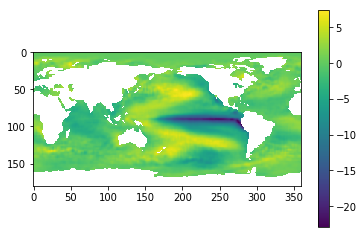

In [112]:
EOF1_res = np.reshape(EOF1_m11, (len(lat_sst), len(lon_sst)))
plt.imshow(EOF1_res)
plt.colorbar()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


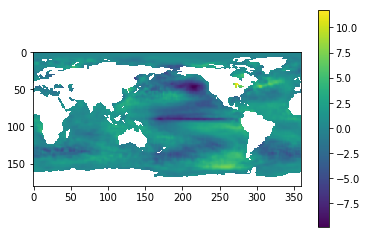

In [113]:
EOF1_m12 = np.ones(len(fila1_A))*np.nan
EOF1_m12[pos_sst] = EOF2_m1
EOF2_res = np.reshape(EOF1_m12, (len(lat_sst), len(lon_sst)))
plt.imshow(EOF2_res)
plt.colorbar()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


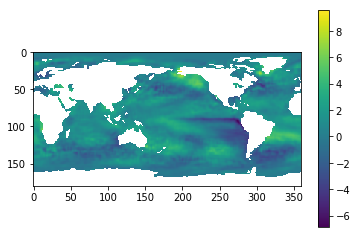

In [114]:
EOF1_m13 = np.ones(len(fila1_A))*np.nan
EOF1_m13[pos_sst] = EOF3_m1
EOF3_res = np.reshape(EOF1_m13, (len(lat_sst), len(lon_sst)))
plt.imshow(EOF3_res)
plt.colorbar()
plt.show()

## Se pinta las componentes principales 
Con el fin de ver si existe tendencia o no.
Bajar U y V en 200mb

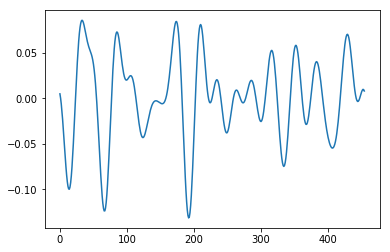

(455,)


In [119]:
# Primer PC
plt.plot(eigvect_covm1[:,0])
plt.show()

print (np.shape(eigvect_covm1[:,0]))

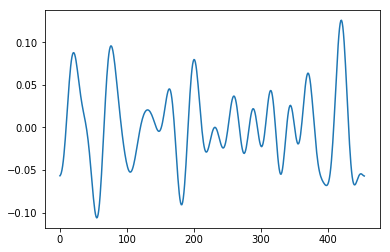

In [120]:
# Primer PC
plt.plot(eigvect_covm1[:,1])
plt.show()

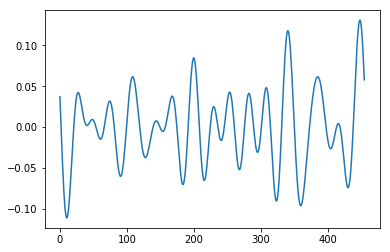

In [121]:
# Primer PC
plt.plot(eigvect_covm1[:,2])
plt.show()

Se puede ver que no existe una clara tendencia  en los PC

# Calculo de las EOFs Extendidas 
Para el mismo fenómeno que estamos mirando hacemos el cálculo de las EOFS Extendidas.

In [1]:
455/36

12.63888888888889

In [128]:
# Denicion del numero de rezagor
# La magtrix de trabajo es m_fourier
print (np.shape(m_fourier))
n_months = 36
step     = 6
n_rez    = int(n_months/step)

(455, 44219)


In [129]:
m_extended = np.ones((np.shape(m_fourier)[0] - n_months, np.shape(m_fourier)[1]*n_rez ))

In [130]:
for i in range(0,n_rez):
    m_extended[:,i*m_fourier.shape[1]:i*m_fourier.shape[1]+m_fourier.shape[1]]=\
        m_fourier[i*step:i*step+(455-n_months),:]

In [147]:
print (np.shape(m_extended))

(419, 265314)


In [133]:
cov_extendida=np.dot(m_extended,m_extended.T)
val1_ext, vec1_ext=la.eig(cov_extendida)

In [134]:
print(val1_ext.shape)
print(vec1_ext.shape)

(419,)
(419, 419)


(0, 10)

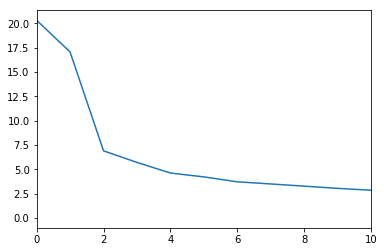

In [137]:
plt.plot((val1_ext/np.sum(val1_ext))*100)
plt.xlim(0,10)

In [138]:
# Encontramos cada una de las EOF
EOFs_ext = np.dot(vec1_ext.T,m_extended)

In [141]:
EOF1_ext = EOFs_ext[0,:]
EOF2_ext = EOFs_ext[1,:]
EOF3_ext = EOFs_ext[2,:]

In [142]:
np.shape(EOFs_ext)

(419, 265314)

In [148]:
print (len(pos_sst))

44219


In [149]:
265314/44219

6

In [158]:
aa = np.copy(EOF1_ext)
aa = aa[]

In [161]:
print (len(aa)/len(pos_sst))

6


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


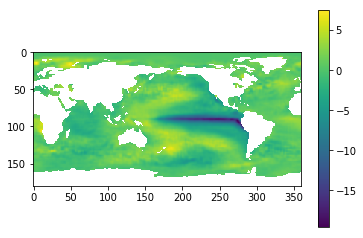

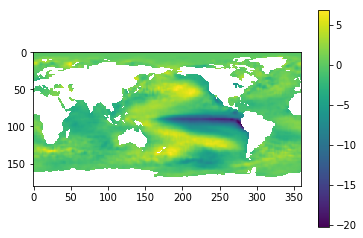

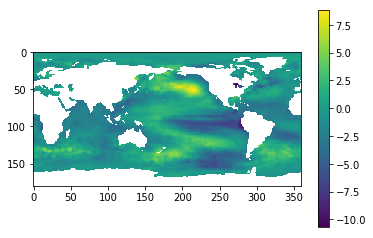

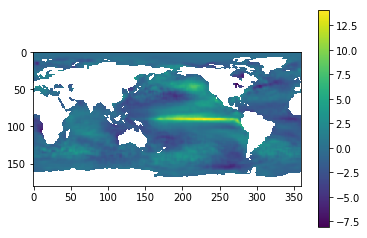

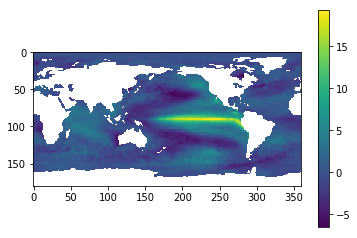

In [163]:
EOF1ext_mres = np.ones((n_rez, len(lat_sst), len(lon_sst))) * np.nan

for j in range(0, n_rez-1):
    EOF1ext_m = np.ones(len(fila1_A))*np.nan
    EOF1ext_m[pos_sst] = EOF1_ext[j*len(pos_sst):j*len(pos_sst)+len(pos_sst)]
    EOF1ext_res = np.reshape(EOF1ext_m, (len(lat_sst), len(lon_sst)))
    plt.imshow(EOF1ext_res)
    plt.colorbar()
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


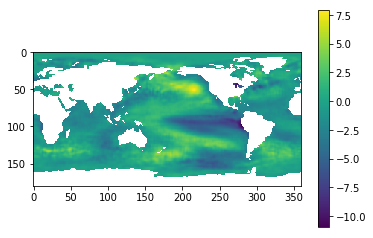

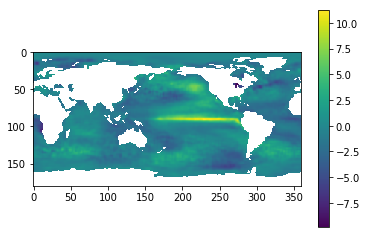

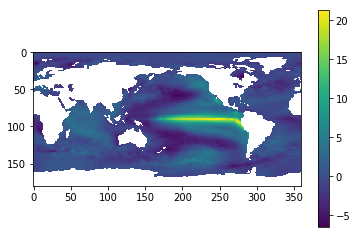

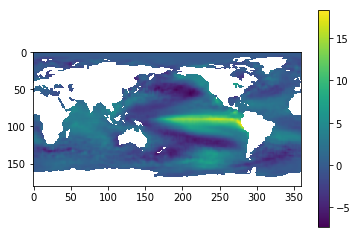

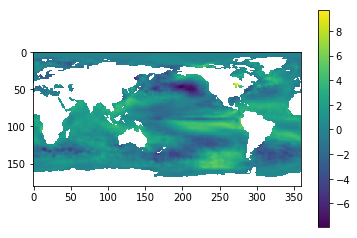

In [164]:
for j in range(0, n_rez-1):
    EOF2ext_m = np.ones(len(fila1_A))*np.nan
    EOF2ext_m[pos_sst] = EOF2_ext[j*len(pos_sst):j*len(pos_sst)+len(pos_sst)]
    EOF2ext_res = np.reshape(EOF2ext_m, (len(lat_sst), len(lon_sst)))
    plt.imshow(EOF2ext_res)
    plt.colorbar()
    plt.show()